In [7]:
import pandas as pd
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class PixelArtDataset(Dataset):
  def __init__(self):
    super(PixelArtDataset).__init__()
    
    self.load_data()
    self.transform = transforms.Compose([
        transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float16),
    ])

  def load_data(self):
    images = os.listdir("./data/images")
    meta = pd.read_parquet("./data/metadata.parquet")
    meta = meta.set_index("image_name")
    
    self.data = []
    for image in images:
      if image in meta.index:
        self.data.append({
          "image_path": os.path.join("./data/images", image),
          "prompt": meta.loc[image, "prompt"],
        })  

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data[idx]
    
    image = Image.open(data["image_path"]).convert("RGB")
    image = self.transform(image)
    
    return {
      "image": image,
      "prompt": data["prompt"],
    }

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(device)

cuda


In [9]:
from diffusers import StableDiffusionPipeline
from diffusers.schedulers import PNDMScheduler

pipe = StableDiffusionPipeline.from_pretrained(
    "sd-legacy/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True
).to(device)

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.requires_grad_(False)

vae = pipe.vae.requires_grad_(False)
unet = pipe.unet
scheduler: PNDMScheduler = pipe.scheduler

unet.train()
pass

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
from torch.nn.functional import mse_loss

TIMESTEPS = torch.tensor(50)

def train_step(dataset, optimizer):
  optimizer.zero_grad()
  
  for index in range(len(dataset)):
    data = dataset[index]
    
    image = data["image"].unsqueeze(0).to(device)
    prompt = data["prompt"]
    
    tokens = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    embeddings = text_encoder(tokens.input_ids).last_hidden_state
  
    latents = vae.encode(image).latent_dist.sample() * vae.config.scaling_factor
    noise = torch.randn_like(latents)
    latents = scheduler.add_noise(latents, noise, TIMESTEPS)
    
    predicted = unet(latents, TIMESTEPS, encoder_hidden_states=embeddings).sample
    
    loss = mse_loss(predicted, noise)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print(f"Processed {index}/{len(dataset)}. Loss: {loss.item()}")

In [11]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-10)

In [13]:
try:
  train_step(PixelArtDataset(), optimizer)
except KeyboardInterrupt:
  print("Training interrupted.")
  pass

Processed 0/2000. Loss: 0.277099609375
Training interrupted.


In [15]:
import numpy as np

def generate_image(prompt: str, iters: int = 100):
  with torch.no_grad():
    tokens = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    embeddings = text_encoder(tokens.input_ids).last_hidden_state
    
    latents = torch.randn((1, unet.config.in_channels, 512 // 8, 512 // 8), dtype=torch.float16).to(device)
    
    scheduler.set_timesteps(iters)
    
    for t in scheduler.timesteps:
      print(f"Processing timestep {(100 - (t.item() * 0.1)):.2f}%")
      latent_model_input = scheduler.scale_model_input(latents, t)
      
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample
      
      latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    image = vae.decode(latents / vae.config.scaling_factor).sample
    image = (image / 2 + 0.5).clamp(0, 1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.float32)
    
    return image

Processing timestep 0.90%
Processing timestep 1.90%
Processing timestep 1.90%
Processing timestep 2.90%
Processing timestep 3.90%
Processing timestep 4.90%
Processing timestep 5.90%
Processing timestep 6.90%
Processing timestep 7.90%
Processing timestep 8.90%
Processing timestep 9.90%
Processing timestep 10.90%
Processing timestep 11.90%
Processing timestep 12.90%
Processing timestep 13.90%
Processing timestep 14.90%
Processing timestep 15.90%
Processing timestep 16.90%
Processing timestep 17.90%
Processing timestep 18.90%
Processing timestep 19.90%
Processing timestep 20.90%
Processing timestep 21.90%
Processing timestep 22.90%
Processing timestep 23.90%
Processing timestep 24.90%
Processing timestep 25.90%
Processing timestep 26.90%
Processing timestep 27.90%
Processing timestep 28.90%
Processing timestep 29.90%
Processing timestep 30.90%
Processing timestep 31.90%
Processing timestep 32.90%
Processing timestep 33.90%
Processing timestep 34.90%
Processing timestep 35.90%
Processing t

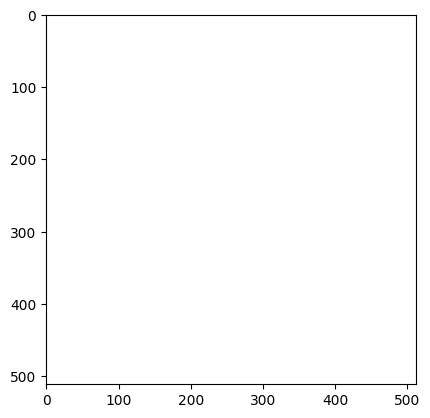

In [16]:
import matplotlib.pyplot as plt

image = generate_image("A cat between a lake and a mountain", 100)

plt.imshow(image)